In [112]:
import pandas as pd

In [113]:
df=pd.read_csv("raw_data.csv")

In [114]:
df['race'] = df['p1_ace'] | df['p2_ace']

In [115]:
import pandas as pd

# 假设 df 是你的数据框，包含了比赛数据

# 使用球员名字进行筛选（假设 'player_name' 列包含球员名字）
player_name = 'Carlos Alcaraz'
matches_of_player = df[df['player1'] == player_name]['match_id'].unique()
df_1 = df[df['match_id']== matches_of_player[0]]
df_1 = df_1.reset_index(drop=True)
df_1

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth,race
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:00:00,1,1,1,0,0,0,...,0,0,6.000,7.840,2,95.0,BC,NCTL,ND,0
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:00:38,1,1,2,0,0,0,...,0,0,5.253,7.094,1,118.0,B,CTL,ND,0
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:01:01,1,1,3,0,0,0,...,0,0,13.800,19.808,4,120.0,B,NCTL,D,0
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:01:31,1,1,4,0,0,0,...,0,0,51.108,75.631,13,130.0,BW,CTL,D,0
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:02:21,1,1,5,0,0,0,...,0,0,0.649,0.813,1,112.0,W,NCTL,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,3:53:25,4,12,296,2,1,6,...,0,0,10.044,9.281,2,130.0,BW,NCTL,ND,0
296,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,3:54:01,4,12,297,2,1,6,...,0,0,52.318,58.723,14,113.0,BW,NCTL,ND,0
297,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,3:55:02,4,12,298,2,1,6,...,0,1,2.056,1.509,1,129.0,B,NCTL,ND,0
298,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,3:55:34,4,12,299,2,1,6,...,0,0,12.292,32.582,1,128.0,C,NCTL,ND,0


In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def calculate_coefficients(df, goal):
    # Drop unnecessary columns for coefficient calculation
    X = df[['Score Factor','Service Factor','Break Factor','Rally Factor','Points Advantage','Serve Advantage','Unforced Errors','Winners']]

    # Replace 2 with 0 in the label column
    y = df[goal]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize logistic regression model
    model = LogisticRegression()

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy (optional)
    accuracy = accuracy_score(y_test, y_pred)
   

    # Get the coefficients
    coefficients = model.coef_[0]

  
    return coefficients


[-2.73880975e-02 -1.23552214e-01  4.35966573e-01  1.56971595e-04
  7.73283995e-01  7.29836910e-01  8.18142045e-01  3.39589591e-01]


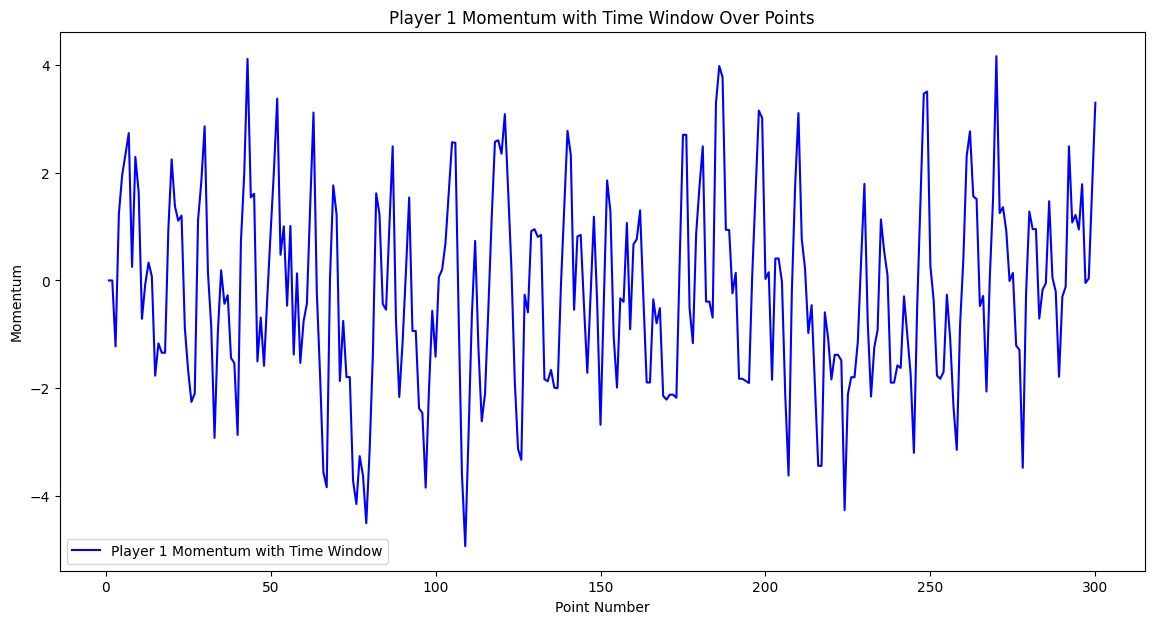

In [117]:
def calculate_p1_momentum_per_point_with_time_window_and_factors(df, window_size=3):
    # Define epsilon to avoid division by zero
    epsilon = 1e-6

    # Calculate the average rally count for the entire match
    average_rally_count = df['rally_count'].mean()

    # Initialize new columns for rolling calculations
    df['p1_long_rallies_won'] = df.apply(lambda row: 1 if (row['rally_count'] > average_rally_count and row['point_victor'] == 1) else 0, axis=1)

    # Initialize columns for factors
    df['Score Factor'] = 0
    df['Service Factor'] = 0
    df['Break Factor'] = 0
    df['Rally Factor'] = 0
    df['Points Advantage'] = 0
    df['Serve Advantage'] = 0
    df['Unforced Errors'] = 0
    df['Winners'] = 0
    df['Momentum'] = 0
    df['Score Factor'] = df["p1_games"]-df["p2_games"]+(df["p1_sets"]-df["p2_sets"])*6
    df['Serve Advantage'] = df['server'].apply(lambda x: 1 if x == 1 else -1)
    # Calculate momentum using a rolling window
    for index in range(len(df)):
        # Determine the start of the time window (ensuring it doesn't go below 0)
        start_index = max(0, index - window_size + 1)
        
        # Create the time window dataframe
        time_window_df = df.iloc[start_index:index + 1]

        # Calculate and store factors
        #df.loc[index, 'Score Factor'] = df["p1_games"]-df["p2_games"]+(df["p1_sets"]-df["p2_sets"])*6
        df.loc[index, 'Service Factor'] = (time_window_df['p1_ace'] - time_window_df['p1_double_fault']).sum() - (time_window_df['p2_ace'] - time_window_df['p2_double_fault']).sum()
        df.loc[index, 'Break Factor'] = ((time_window_df['p1_break_pt_won'] - time_window_df['p1_break_pt_missed']).sum() - 
                                         (time_window_df['p2_break_pt_won'] - time_window_df['p2_break_pt_missed']).sum()) / (time_window_df[['p1_break_pt', 'p2_break_pt']].sum().sum() + epsilon)
        df.loc[index, 'Rally Factor'] = df['p1_long_rallies_won'].sum() / (df['rally_count'].apply(lambda x: 1 if x > average_rally_count else 0).sum() + epsilon)
        df.loc[index, 'Points Advantage'] = time_window_df['point_victor'].apply(lambda x: 1 if x == 1 else 0).sum() - time_window_df['point_victor'].apply(lambda x: 1 if x == 2 else 0).sum()
        #df.loc[index, 'Serve Advantage'] = time_window_df.apply(lambda row: (row['server'] == 1 and row['point_victor'] == 1) * 0.1, axis=1).sum()
        df.loc[index, 'Unforced Errors'] = -time_window_df['p1_unf_err'].sum()
        df.loc[index, 'Winners'] = time_window_df['p1_winner'].sum()

        # Calculate the total momentum using the factors

        coefficients = calculate_coefficients(df, "p1_victor")
   

        total_momentum = (
        coefficients[0] * df.loc[index, 'Score Factor'] +
        coefficients[1] * df.loc[index, 'Service Factor'] +
        coefficients[2] * df.loc[index, 'Break Factor'] +
        coefficients[3] * df.loc[index, 'Rally Factor'] +
        coefficients[4] * df.loc[index, 'Points Advantage'] +
        coefficients[5] * df.loc[index, 'Serve Advantage'] +
        coefficients[6] * df.loc[index, 'Unforced Errors'] +
        coefficients[7] * df.loc[index, 'Winners']
)

        

        # Set the momentum for the current point
        df.loc[index, 'Momentum'] = total_momentum if index >= window_size - 1 else 0
    print(coefficients)
    return df

# Since the environment was reset, we need to reload the data

df_1['p1_victor'] = df_1['point_victor'].replace(2, 0)
# Apply the modified function to the dataframe
df_with_momentum_p1 = calculate_p1_momentum_per_point_with_time_window_and_factors(df_1.copy(), window_size=3)

# Display the first few rows to verify the new columns

df_with_momentum_p1[['point_no', 'Score Factor', 'Service Factor', 'Break Factor', 'Rally Factor', 'Points Advantage', 'Serve Advantage', 'Unforced Errors', 'Winners', 'Momentum']].head()

plt.figure(figsize=(14, 7))
plt.plot(df_with_momentum_p1['point_no'], df_with_momentum_p1['Momentum'], label='Player 1 Momentum with Time Window', color='blue')
plt.xlabel('Point Number')
plt.ylabel('Momentum')
plt.title('Player 1 Momentum with Time Window Over Points')
plt.legend()
plt.show()


[-7.85114068e-03  4.56508067e-01  9.60146188e-01 -8.20842390e-05
  0.00000000e+00 -7.30347059e-01  7.52640985e-01 -1.04202846e-01]


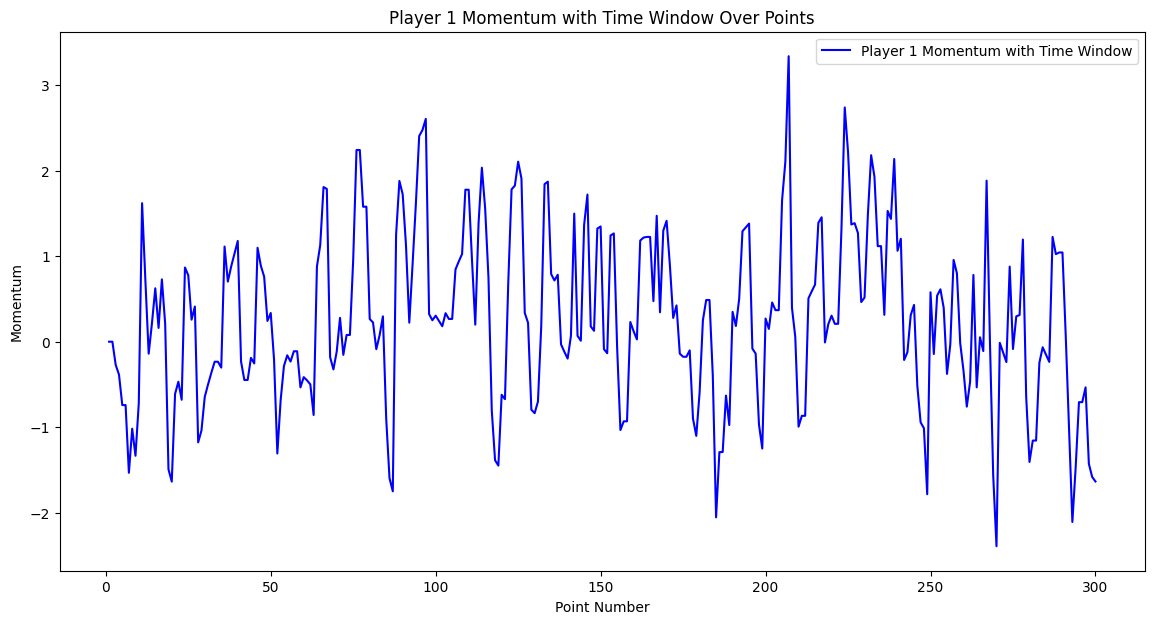

In [118]:
def calculate_p2_momentum_per_point_with_time_window_and_factors(df, window_size=3):
    # Define epsilon to avoid division by zero
    epsilon = 1e-6

    # Calculate the average rally count for the entire match
    average_rally_count = df['rally_count'].mean()

    # Initialize new columns for rolling calculations
    df['p2_long_rallies_won'] = df.apply(lambda row: 1 if (row['rally_count'] > average_rally_count and row['point_victor'] == 1) else 0, axis=1)

    # Initialize columns for factors
    df['Score Factor'] = 0
    df['Service Factor'] = 0
    df['Break Factor'] = 0
    df['Rally Factor'] = 0
    df['Points Advantage'] = 0
    df['Serve Advantage'] = 0
    df['Unforced Errors'] = 0
    df['Winners'] = 0
    df['Momentum'] = 0
    df['Score Factor'] = df["p2_games"]-df["p1_games"]+(df["p2_sets"]-df["p1_sets"])*6
    df['Serve Advantage'] = df['server'].apply(lambda x: 1 if x == 1 else -1)
    # Calculate momentum using a rolling window
    for index in range(len(df)):
        # Determine the start of the time window (ensuring it doesn't go below 0)
        start_index = max(0, index - window_size + 1)
        
        # Create the time window dataframe
        time_window_df = df.iloc[start_index:index + 1]

        # Calculate and store factors
        #df.loc[index, 'Score Factor'] = df["p2_games"]-df["p1_games"]+(df["p2_sets"]-df["p1_sets"])*6
        df.loc[index, 'Service Factor'] = (time_window_df['p2_ace'] - time_window_df['p2_double_fault']).sum() - (time_window_df['p1_ace'] - time_window_df['p1_double_fault']).sum()
        df.loc[index, 'Break Factor'] = ((time_window_df['p2_break_pt_won'] - time_window_df['p2_break_pt_missed']).sum() - 
                                         (time_window_df['p1_break_pt_won'] - time_window_df['p1_break_pt_missed']).sum()) / (time_window_df[['p2_break_pt', 'p1_break_pt']].sum().sum() + epsilon)
        df.loc[index, 'Rally Factor'] = df['p2_long_rallies_won'].sum() / (df['rally_count'].apply(lambda x: 1 if x > average_rally_count else 0).sum() + epsilon)
        df.loc[index, 'Points Advantage'] = time_window_df['point_victor'].apply(lambda x: 1 if x == 2 else 0).sum() - time_window_df['point_victor'].apply(lambda x: 1 if x == 2 else 0).sum()
        #df.loc[index, 'Serve Advantage'] = time_window_df.apply(lambda row: (row['server'] == 1 and row['point_victor'] == 1) * 0.1, axis=1).sum()
        df.loc[index, 'Unforced Errors'] = -time_window_df['p2_unf_err'].sum()
        df.loc[index, 'Winners'] = time_window_df['p2_winner'].sum()

        # Calculate the total momentum using the factors

        coefficients = calculate_coefficients(df, "p2_victor")
   

        total_momentum = (
        coefficients[0] * df.loc[index, 'Score Factor'] +
        coefficients[1] * df.loc[index, 'Service Factor'] +
        coefficients[2] * df.loc[index, 'Break Factor'] +
        coefficients[3] * df.loc[index, 'Rally Factor'] +
        coefficients[4] * df.loc[index, 'Points Advantage'] +
        coefficients[5] * df.loc[index, 'Serve Advantage'] +
        coefficients[6] * df.loc[index, 'Unforced Errors'] +
        coefficients[7] * df.loc[index, 'Winners']
)

        

        # Set the momentum for the current point
        df.loc[index, 'Momentum'] = total_momentum if index >= window_size - 1 else 0
    print(coefficients)
    return df

# Since the environment was reset, we need to reload the data

df_1['p2_victor'] = df_1['point_victor'].replace(1, 0)
# Apply the modified function to the dataframe
df_with_momentum_p2 = calculate_p2_momentum_per_point_with_time_window_and_factors(df_1.copy(), window_size=3)

# Display the first few rows to verify the new columns

df_with_momentum_p2[['point_no', 'Score Factor', 'Service Factor', 'Break Factor', 'Rally Factor', 'Points Advantage', 'Serve Advantage', 'Unforced Errors', 'Winners', 'Momentum']].head()

plt.figure(figsize=(14, 7))
plt.plot(df_with_momentum_p2['point_no'], df_with_momentum_p2['Momentum'], label='Player 1 Momentum with Time Window', color='blue')
plt.xlabel('Point Number')
plt.ylabel('Momentum')
plt.title('Player 1 Momentum with Time Window Over Points')
plt.legend()
plt.show()

第一问前三条整图

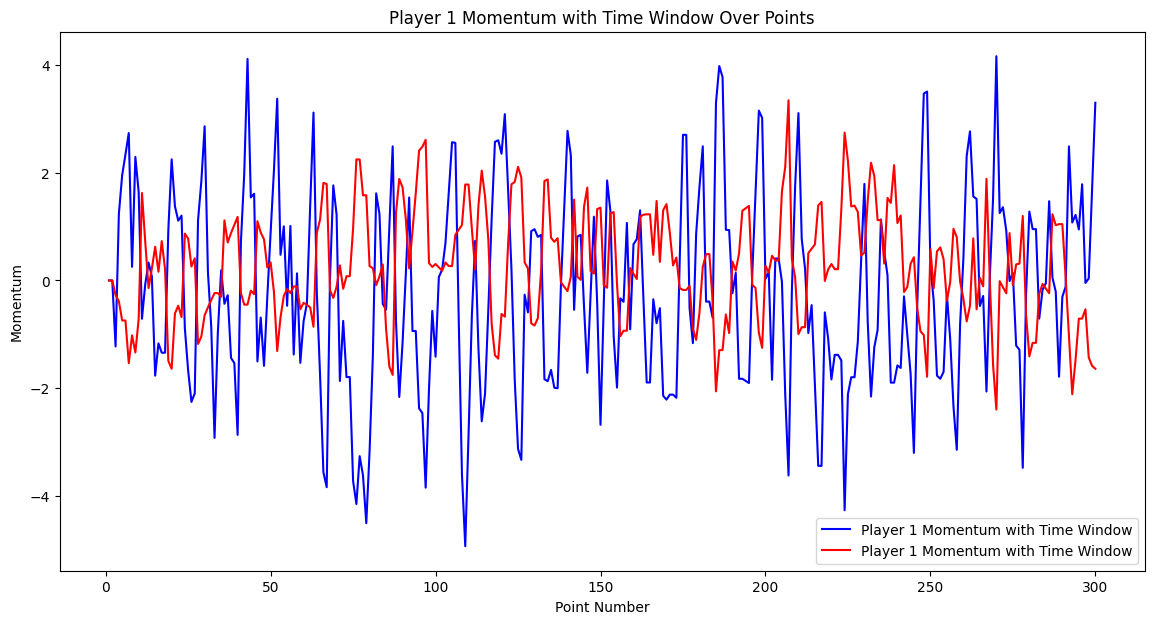

In [119]:
plt.figure(figsize=(14, 7))
plt.plot(df_with_momentum_p1['point_no'], df_with_momentum_p1['Momentum'], label='Player 1 Momentum with Time Window', color='blue')
plt.plot(df_with_momentum_p2['point_no'], df_with_momentum_p2['Momentum'], label='Player 1 Momentum with Time Window', color='red')
plt.xlabel('Point Number')
plt.ylabel('Momentum')
plt.title('Player 1 Momentum with Time Window Over Points')
plt.legend()
plt.show()

[-1.26116365e-02 -7.48708553e-02 -2.36754282e-01 -2.47366463e-05
  2.29542295e-01  7.51867858e-01  2.78832696e-01  5.91451962e-02]


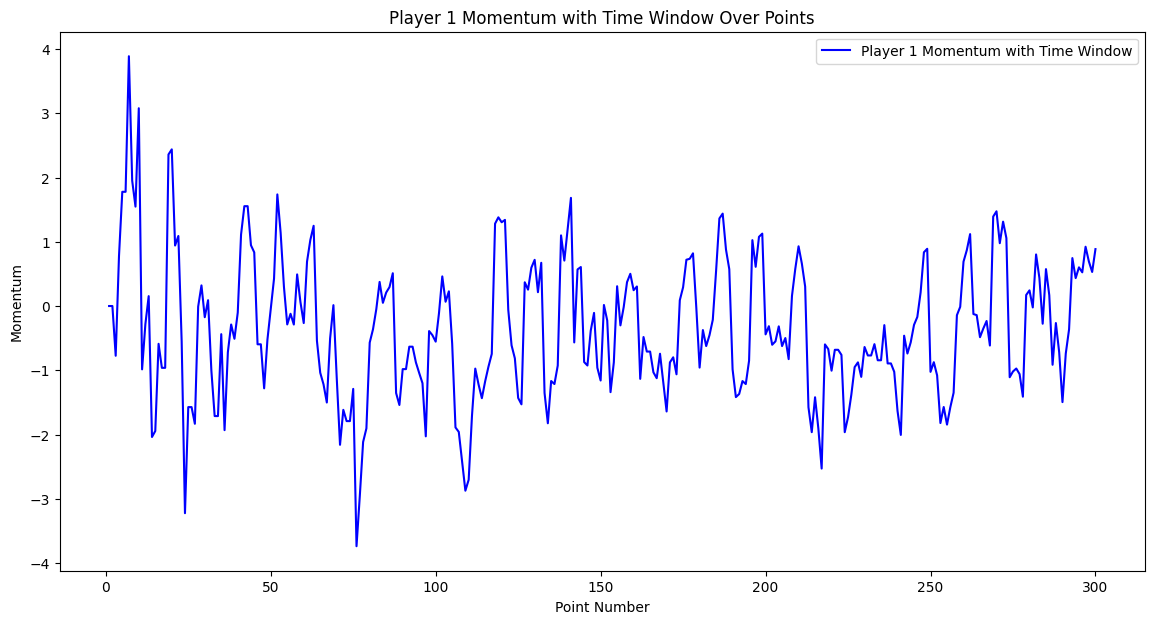

In [120]:
def calculate_p1_momentum_per_point_with_time_window_and_factors_glo(df, window_size=3):
    # Define epsilon to avoid division by zero
    epsilon = 1e-6

    # Calculate the average rally count for the entire match
    average_rally_count = df['rally_count'].mean()

    # Initialize new columns for rolling calculations
    df['p1_long_rallies_won'] = df.apply(lambda row: 1 if (row['rally_count'] > average_rally_count and row['point_victor'] == 1) else 0, axis=1)

    # Initialize columns for factors
    df['Score Factor'] = 0
    df['Service Factor'] = 0
    df['Break Factor'] = 0
    df['Rally Factor'] = 0
    df['Points Advantage'] = 0
    df['Serve Advantage'] = 0
    df['Unforced Errors'] = 0
    df['Winners'] = 0
    df['Momentum'] = 0
    df['Score Factor'] = df["p1_games"]-df["p2_games"]+(df["p1_sets"]-df["p2_sets"])*6
    df['Serve Advantage'] = df['server'].apply(lambda x: 1 if x == 1 else -1)
    # Calculate momentum using a rolling window
    for index in range(len(df)):
        # Determine the start of the time window (ensuring it doesn't go below 0)
        start_index = max(0, index - window_size )
        end_index = min(index + window_size + 1, len(df))
        # Create the time window dataframe
        time_window_df = df.iloc[start_index:end_index]

        # Calculate and store factors
        #df.loc[index, 'Score Factor'] = df["p1_games"]-df["p2_games"]+(df["p1_sets"]-df["p2_sets"])*6
        df.loc[index, 'Service Factor'] = (time_window_df['p1_ace'] - time_window_df['p1_double_fault']).sum() - (time_window_df['p2_ace'] - time_window_df['p2_double_fault']).sum()
        df.loc[index, 'Break Factor'] = ((time_window_df['p1_break_pt_won'] - time_window_df['p1_break_pt_missed']).sum() - 
                                         (time_window_df['p2_break_pt_won'] - time_window_df['p2_break_pt_missed']).sum()) / (time_window_df[['p1_break_pt', 'p2_break_pt']].sum().sum() + epsilon)
        df.loc[index, 'Rally Factor'] = df['p1_long_rallies_won'].sum() / (df['rally_count'].apply(lambda x: 1 if x > average_rally_count else 0).sum() + epsilon)
        df.loc[index, 'Points Advantage'] = time_window_df['point_victor'].apply(lambda x: 1 if x == 1 else 0).sum() - time_window_df['point_victor'].apply(lambda x: 1 if x == 2 else 0).sum()
        #df.loc[index, 'Serve Advantage'] = time_window_df.apply(lambda row: (row['server'] == 1 and row['point_victor'] == 1) * 0.1, axis=1).sum()
        df.loc[index, 'Unforced Errors'] = -time_window_df['p1_unf_err'].sum()
        df.loc[index, 'Winners'] = time_window_df['p1_winner'].sum()

        # Calculate the total momentum using the factors

        coefficients = calculate_coefficients(df, "p1_victor")
   

        total_momentum = (
        coefficients[0] * df.loc[index, 'Score Factor'] +
        coefficients[1] * df.loc[index, 'Service Factor'] +
        coefficients[2] * df.loc[index, 'Break Factor'] +
        coefficients[3] * df.loc[index, 'Rally Factor'] +
        coefficients[4] * df.loc[index, 'Points Advantage'] +
        coefficients[5] * df.loc[index, 'Serve Advantage'] +
        coefficients[6] * df.loc[index, 'Unforced Errors'] +
        coefficients[7] * df.loc[index, 'Winners']
)

        

        # Set the momentum for the current point
        df.loc[index, 'Momentum'] = total_momentum if index >= window_size - 1 else 0
    print(coefficients)
    return df

# Since the environment was reset, we need to reload the data

df_1['p1_victor'] = df_1['point_victor'].replace(2, 0)
# Apply the modified function to the dataframe
df_with_momentum_p1_glo = calculate_p1_momentum_per_point_with_time_window_and_factors_glo(df_1.copy(), window_size=3)

# Display the first few rows to verify the new columns

df_with_momentum_p1_glo[['point_no', 'Score Factor', 'Service Factor', 'Break Factor', 'Rally Factor', 'Points Advantage', 'Serve Advantage', 'Unforced Errors', 'Winners', 'Momentum']].head()

plt.figure(figsize=(14, 7))
plt.plot(df_with_momentum_p1_glo['point_no'], df_with_momentum_p1_glo['Momentum'], label='Player 1 Momentum with Time Window', color='blue')
plt.xlabel('Point Number')
plt.ylabel('Momentum')
plt.title('Player 1 Momentum with Time Window Over Points')
plt.legend()
plt.show()

[-7.85114068e-03  4.56508067e-01  9.60146188e-01 -8.20842390e-05
  0.00000000e+00 -7.30347059e-01  7.52640985e-01 -1.04202846e-01]


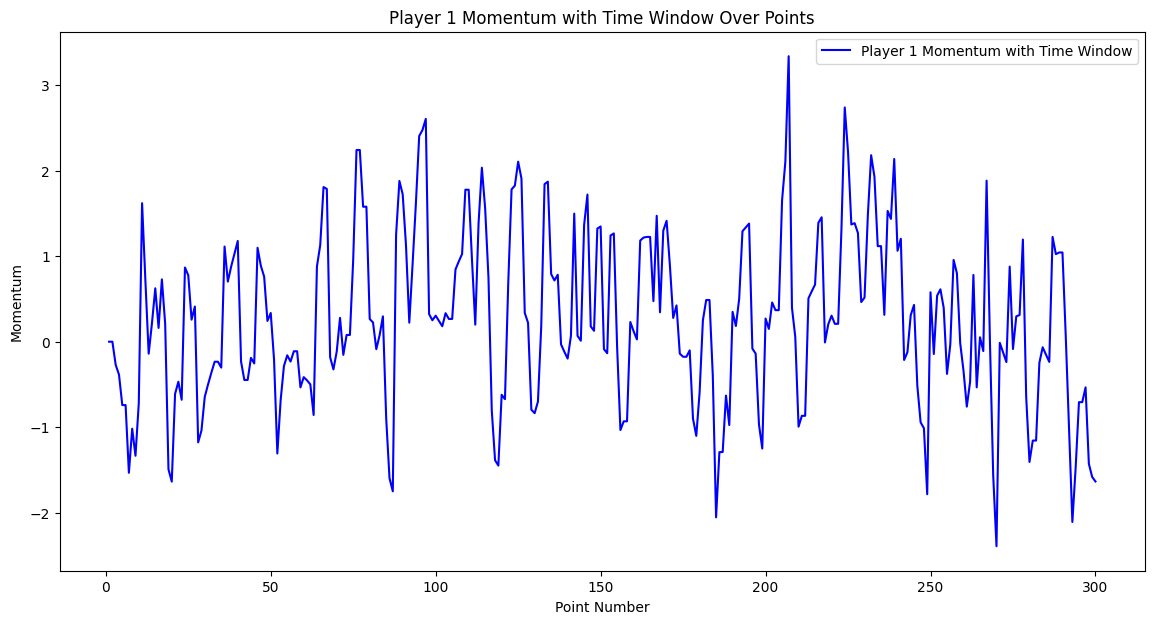

In [121]:
def calculate_p2_momentum_per_point_with_time_window_and_factors_glo(df, window_size=3):
    # Define epsilon to avoid division by zero
    epsilon = 1e-6

    # Calculate the average rally count for the entire match
    average_rally_count = df['rally_count'].mean()

    # Initialize new columns for rolling calculations
    df['p2_long_rallies_won'] = df.apply(lambda row: 1 if (row['rally_count'] > average_rally_count and row['point_victor'] == 1) else 0, axis=1)

    # Initialize columns for factors
    df['Score Factor'] = 0
    df['Service Factor'] = 0
    df['Break Factor'] = 0
    df['Rally Factor'] = 0
    df['Points Advantage'] = 0
    df['Serve Advantage'] = 0
    df['Unforced Errors'] = 0
    df['Winners'] = 0
    df['Momentum'] = 0
    df['Score Factor'] = df["p2_games"]-df["p1_games"]+(df["p2_sets"]-df["p1_sets"])*6
    df['Serve Advantage'] = df['server'].apply(lambda x: 1 if x == 1 else -1)
    # Calculate momentum using a rolling window
    for index in range(len(df)):
        # Determine the start of the time window (ensuring it doesn't go below 0)
        start_index = max(0, index - window_size )
        end_index = min(index + window_size + 1, len(df))
        # Create the time window dataframe
        time_window_df = df.iloc[start_index:end_index]

        # Calculate and store factors
        #df.loc[index, 'Score Factor'] = df["p2_games"]-df["p1_games"]+(df["p2_sets"]-df["p1_sets"])*6
        df.loc[index, 'Service Factor'] = (time_window_df['p2_ace'] - time_window_df['p2_double_fault']).sum() - (time_window_df['p1_ace'] - time_window_df['p1_double_fault']).sum()
        df.loc[index, 'Break Factor'] = ((time_window_df['p2_break_pt_won'] - time_window_df['p2_break_pt_missed']).sum() - 
                                         (time_window_df['p1_break_pt_won'] - time_window_df['p1_break_pt_missed']).sum()) / (time_window_df[['p2_break_pt', 'p1_break_pt']].sum().sum() + epsilon)
        df.loc[index, 'Rally Factor'] = df['p2_long_rallies_won'].sum() / (df['rally_count'].apply(lambda x: 1 if x > average_rally_count else 0).sum() + epsilon)
        df.loc[index, 'Points Advantage'] = time_window_df['point_victor'].apply(lambda x: 1 if x == 2 else 0).sum() - time_window_df['point_victor'].apply(lambda x: 1 if x == 2 else 0).sum()
        #df.loc[index, 'Serve Advantage'] = time_window_df.apply(lambda row: (row['server'] == 1 and row['point_victor'] == 1) * 0.1, axis=1).sum()
        df.loc[index, 'Unforced Errors'] = -time_window_df['p2_unf_err'].sum()
        df.loc[index, 'Winners'] = time_window_df['p2_winner'].sum()

        # Calculate the total momentum using the factors

        coefficients = calculate_coefficients(df, "p2_victor")
   

        total_momentum = (
        coefficients[0] * df.loc[index, 'Score Factor'] +
        coefficients[1] * df.loc[index, 'Service Factor'] +
        coefficients[2] * df.loc[index, 'Break Factor'] +
        coefficients[3] * df.loc[index, 'Rally Factor'] +
        coefficients[4] * df.loc[index, 'Points Advantage'] +
        coefficients[5] * df.loc[index, 'Serve Advantage'] +
        coefficients[6] * df.loc[index, 'Unforced Errors'] +
        coefficients[7] * df.loc[index, 'Winners']
)

        

        # Set the momentum for the current point
        df.loc[index, 'Momentum'] = total_momentum if index >= window_size - 1 else 0
    print(coefficients)
    return df

# Since the environment was reset, we need to reload the data

df_1['p2_victor'] = df_1['point_victor'].replace(1, 0)
# Apply the modified function to the dataframe
df_with_momentum_p2_glo = calculate_p2_momentum_per_point_with_time_window_and_factors(df_1.copy(), window_size=3)

# Display the first few rows to verify the new columns

df_with_momentum_p2_glo[['point_no', 'Score Factor', 'Service Factor', 'Break Factor', 'Rally Factor', 'Points Advantage', 'Serve Advantage', 'Unforced Errors', 'Winners', 'Momentum']].head()

plt.figure(figsize=(14, 7))
plt.plot(df_with_momentum_p2_glo['point_no'], df_with_momentum_p2_glo['Momentum'], label='Player 1 Momentum with Time Window', color='blue')
plt.xlabel('Point Number')
plt.ylabel('Momentum')
plt.title('Player 1 Momentum with Time Window Over Points')
plt.legend()
plt.show()

第一问global整图

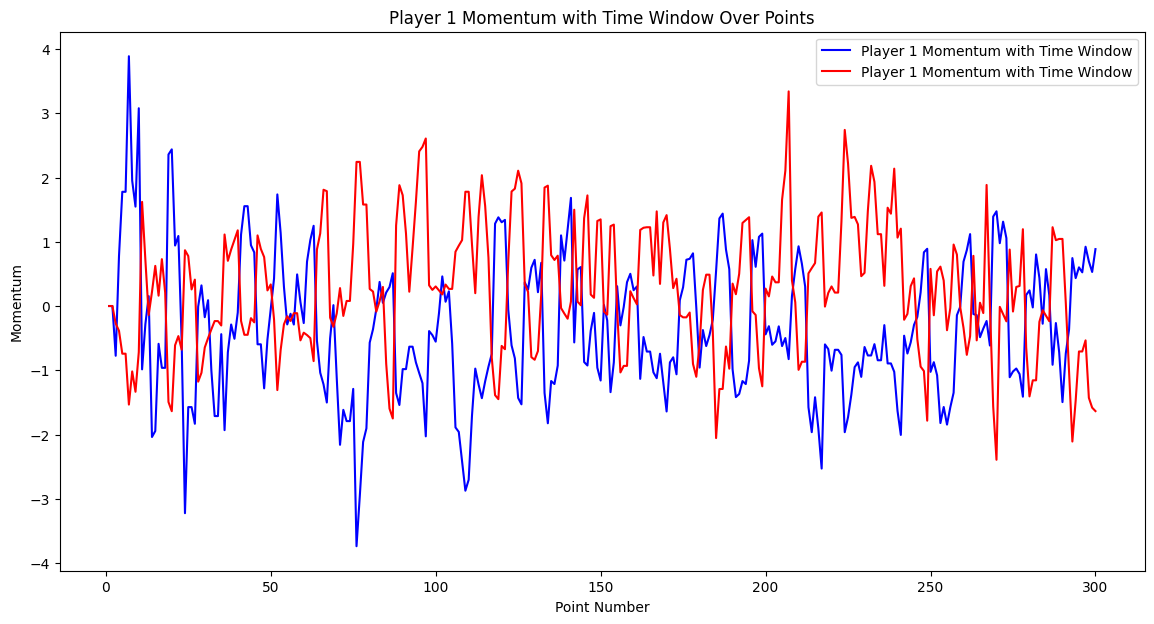

In [122]:
plt.figure(figsize=(14, 7))
plt.plot(df_with_momentum_p1_glo['point_no'], df_with_momentum_p1_glo['Momentum'], label='Player 1 Momentum with Time Window', color='blue')
plt.plot(df_with_momentum_p2_glo['point_no'], df_with_momentum_p2_glo['Momentum'], label='Player 1 Momentum with Time Window', color='red')
plt.xlabel('Point Number')
plt.ylabel('Momentum')
plt.title('Player 1 Momentum with Time Window Over Points')
plt.legend()
plt.show()

标记突变点

In [123]:
def cumsum_detection(series):
    """
    CUMSUM检测算法实现，用于检测序列中的转折点。
    :param series: 一维数据序列 (Pandas Series)
    :return: 转折点的索引列表
    """
    # 计算差分序列
    diff_series = series.diff().fillna(0)  # 用0填充NaN值
    
    # 计算累积和
    cumsum_series = diff_series.cumsum()
    
    # 识别转折点：当累积和重新穿过零点时，认为是一个转折点
    turning_points = []
    for i in range(1, len(cumsum_series)):
        # 如果累积和的符号与前一个不同，则认为是转折点
        if cumsum_series[i] * cumsum_series[i-1] < 0:
            turning_points.append(i)
    
    return turning_points

In [124]:
# 应用CUMSUM检测算法来识别两位球员势头的转折点
p1_turning_points = cumsum_detection(df_with_momentum_p1_glo['Momentum'])
p2_turning_points = cumsum_detection(df_with_momentum_p2_glo['Momentum'])

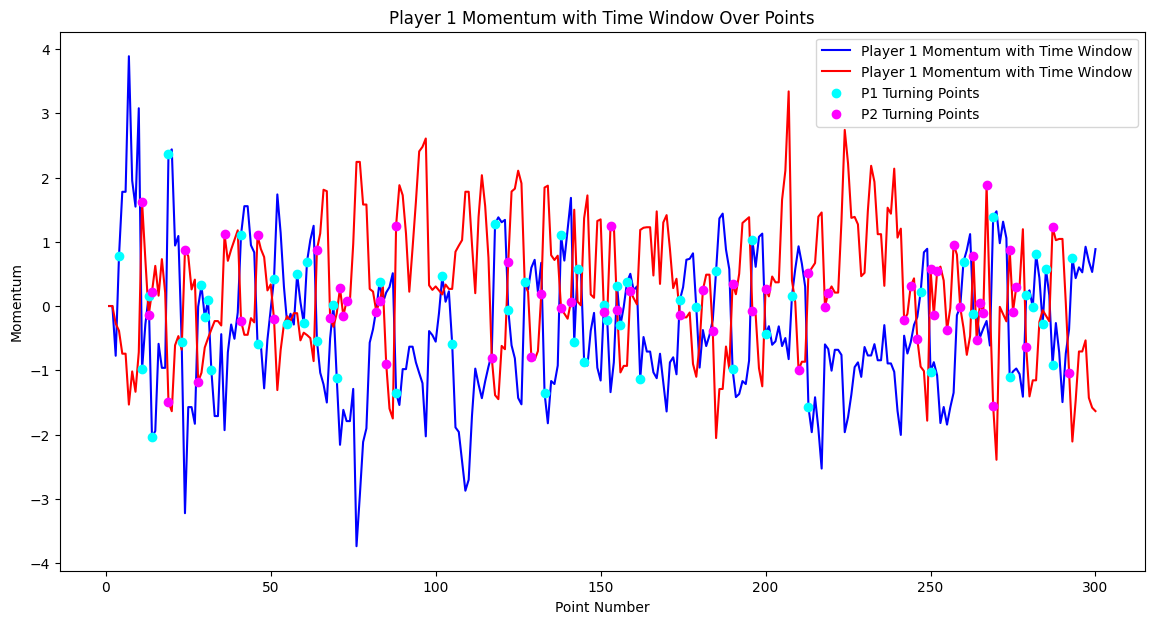

In [125]:
plt.figure(figsize=(14, 7))
plt.plot(df_with_momentum_p1_glo['point_no'], df_with_momentum_p1_glo['Momentum'], label='Player 1 Momentum with Time Window', color='blue')
plt.plot(df_with_momentum_p2_glo['point_no'], df_with_momentum_p2_glo['Momentum'], label='Player 1 Momentum with Time Window', color='red')

plt.scatter(df_with_momentum_p1_glo['point_no'].iloc[p1_turning_points], df_with_momentum_p1_glo['Momentum'].iloc[p1_turning_points], color='cyan', label='P1 Turning Points', zorder=5)
plt.scatter(df_with_momentum_p2_glo['point_no'].iloc[p2_turning_points], df_with_momentum_p2_glo['Momentum'].iloc[p2_turning_points], color='magenta', label='P2 Turning Points', zorder=5)

plt.xlabel('Point Number')
plt.ylabel('Momentum')
plt.title('Player 1 Momentum with Time Window Over Points')
plt.legend()
plt.show()

第二问

In [126]:
df_with_momentum_p1["p1_score_diff"]=df_with_momentum_p1['p1_points_won'].diff().dropna()
df_with_momentum_p1["p1_score_diff"].dropna()
df_with_momentum_p1["p1_score_diff"][0]=0
df_with_momentum_p1

C:\Users\86191\AppData\Local\Temp\ipykernel_45448\4230484592.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_momentum_p1["p1_score_diff"][0]=0


,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,Score Factor,Service Factor,Break Factor,Rally Factor,Points Advantage,Serve Advantage,Unforced Errors,Winners,Momentum,p1_score_diff
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:00:00,1,1,1,0,0,0,...,0,0,0.000000,0.652632,-1,1,-1,0,0.000000,0.0
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:00:38,1,1,2,0,0,0,...,0,0,0.000000,0.652632,0,1,-1,0,0.000000,1.0
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:01:01,1,1,3,0,0,0,...,0,0,0.000000,0.652632,-1,1,-2,0,-1.223483,0.0
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:01:31,1,1,4,0,0,0,...,0,0,0.000000,0.652632,1,1,-1,1,1.230670,1.0
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:02:21,1,1,5,0,0,0,...,0,1,0.000000,0.652632,1,1,-1,2,1.953028,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,3:53:25,4,12,296,2,1,6,...,7,0,0.000000,0.652632,1,1,0,1,1.783660,0.0
296,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,3:54:01,4,12,297,2,1,6,...,7,0,0.000000,0.652632,-1,1,0,1,-0.046429,0.0
297,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,3:55:02,4,12,298,2,1,6,...,7,0,0.999999,0.652632,-1,1,0,0,0.036403,1.0
298,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,3:55:34,4,12,299,2,1,6,...,7,0,0.999999,0.652632,1,1,0,0,1.676904,1.0


In [127]:
df_with_momentum_p1["momen_diff"]=df_with_momentum_p1['Momentum'].diff().dropna()
df_with_momentum_p1["momen_diff"].dropna()
df_with_momentum_p1["momen_diff"][0]=0
df_with_momentum_p1

C:\Users\86191\AppData\Local\Temp\ipykernel_45448\3957632386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_momentum_p1["momen_diff"][0]=0


,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,Service Factor,Break Factor,Rally Factor,Points Advantage,Serve Advantage,Unforced Errors,Winners,Momentum,p1_score_diff,momen_diff
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:00:00,1,1,1,0,0,0,...,0,0.000000,0.652632,-1,1,-1,0,0.000000,0.0,0.000000
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:00:38,1,1,2,0,0,0,...,0,0.000000,0.652632,0,1,-1,0,0.000000,1.0,0.000000
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:01:01,1,1,3,0,0,0,...,0,0.000000,0.652632,-1,1,-2,0,-1.223483,0.0,-1.223483
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:01:31,1,1,4,0,0,0,...,0,0.000000,0.652632,1,1,-1,1,1.230670,1.0,2.454154
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,0:02:21,1,1,5,0,0,0,...,1,0.000000,0.652632,1,1,-1,2,1.953028,1.0,0.722358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,3:53:25,4,12,296,2,1,6,...,0,0.000000,0.652632,1,1,0,1,1.783660,0.0,0.837974
296,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,3:54:01,4,12,297,2,1,6,...,0,0.000000,0.652632,-1,1,0,1,-0.046429,0.0,-1.830089
297,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,3:55:02,4,12,298,2,1,6,...,0,0.999999,0.652632,-1,1,0,0,0.036403,1.0,0.082832
298,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,3:55:34,4,12,299,2,1,6,...,0,0.999999,0.652632,1,1,0,0,1.676904,1.0,1.640501


In [128]:
# df_with_momentum_p1.to_csv("df_with_momentum_p1_3.csv")

In [129]:
df_with_momentum_p1["fluc_point"]=0
df_with_momentum_p1["fluc_point"].iloc[p1_turning_points]=1

df_with_momentum_p1.to_csv("game_1.csv")

C:\Users\86191\AppData\Local\Temp\ipykernel_45448\904768300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_momentum_p1["fluc_point"].iloc[p1_turning_points]=1
c:\Users\86191\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\blocks.py:2321: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


c:\Users\86191\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\blocks.py:2321: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


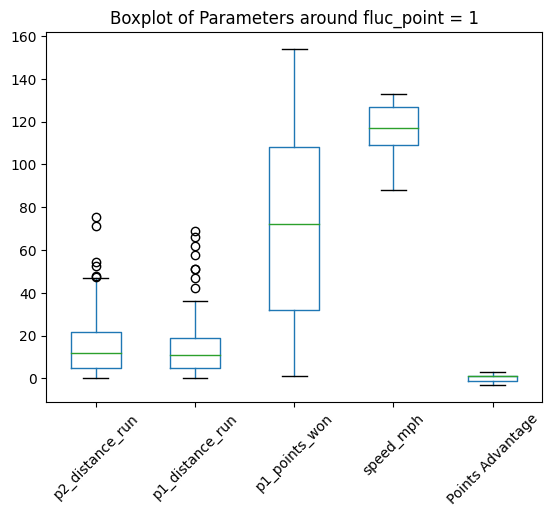

In [196]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设df是你的数据框，包含fluc_point列
# 注意：以下示例中的列名是伪造的，根据你的实际数据替换列名
df_temp = df_with_momentum_p1

# 选择fluc_point = 1附近的数据，假设范围是前后两个数据点
fluc_range = 1  # 设置范围
fluc_index = df_temp[df_temp['fluc_point'] == 1].index

# 获取fluc_point = 1附近的数据
subset_indices = [idx for fluc_idx in fluc_index for idx in range(fluc_idx - fluc_range, fluc_idx + fluc_range + 1)]
subset = df_temp.loc[subset_indices].drop_duplicates()


# 计算均值、方差等统计指标
# stats = subset.describe()


# subset.reset_index(drop= False)

# print(subset.columns)

subset.to_csv('subset.csv')


# 绘制箱线图
#["momen_diff", "Momentum", "p2_distance_run", "p1_distance_run",
# "p2_points_won", "p1_points_won","speed_mph", "p1_games", "rally_count", "p2_games"]
subset.boxplot(column=["p2_distance_run", "p1_distance_run","p1_points_won","speed_mph", "Points Advantage"], grid=False)
plt.title('Boxplot of Parameters around fluc_point = 1')
plt.xticks(rotation=45)
plt.show()

In [130]:
import pandas as pd

# 读取五个表格
df1 = pd.read_csv('game_1.csv')
df2 = pd.read_csv('game_2.csv')
df3 = pd.read_csv('game_3.csv')
df4 = pd.read_csv('game_4.csv')
df5 = pd.read_csv('game_5.csv')

# 为每个表格的列添加标号
df1 = df1.add_suffix('_game_1')
df2 = df2.add_suffix('_game_2')
df3 = df3.add_suffix('_game_3')
df4 = df4.add_suffix('_game_4')
df5 = df5.add_suffix('_game_5')

# 将表格逐列合并
merged_df = pd.concat([df1, df2, df3, df4, df5], axis=1)

merged_df = merged_df.fillna(0)

merged_df.to_csv('merged_game.csv')

# 打印合并后的DataFrame
print(merged_df)


     Unnamed: 0_game_1      match_id_game_1  player1_game_1 player2_game_1  \
0                  0.0  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry   
1                  1.0  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry   
2                  2.0  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry   
3                  3.0  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry   
4                  4.0  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry   
..                 ...                  ...             ...            ...   
329                0.0                    0               0              0   
330                0.0                    0               0              0   
331                0.0                    0               0              0   
332                0.0                    0               0              0   
333                0.0                    0               0              0   

    elapsed_time_game_1  set_no_game_1  game_no_game_1  point_n

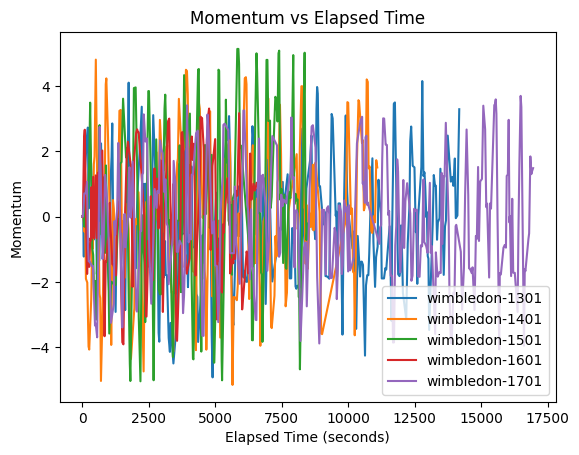

In [131]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取五个表格
df1 = pd.read_csv('game_1.csv')
df2 = pd.read_csv('game_2.csv')
df3 = pd.read_csv('game_3.csv')
df4 = pd.read_csv('game_4.csv')
df5 = pd.read_csv('game_5.csv')

# 将五个表格合并为一个DataFrame
data = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

# 将elapsed_time列转换为秒数
data['elapsed_time_seconds'] = pd.to_timedelta(data['elapsed_time']).dt.total_seconds()

# 针对每个match_id创建折线图
for match_id, group in data.groupby('match_id'):
    plt.plot(group['elapsed_time_seconds'], group['Momentum'], label=f'{match_id}'[5:])

# 设置图表标题和轴标签
plt.title('Momentum vs Elapsed Time')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Momentum')

# 显示图例
plt.legend()

# 显示图表
plt.show()
